In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras.regularizers import *
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
tokenizer = Tokenizer()
data = open('tmp2/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [3]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length = max_sequence_len - 1))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.15))
model.add(LSTM(64))
model.add(Dense(total_words // 2, activation='relu', 
          kernel_regularizer = L2(0.01)))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(), metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 256)           234496    
_________________________________________________________________
dropout (Dropout)            (None, 10, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense (Dense)                (None, 1605)              104325    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 5,898,963
Trainable params: 5,898,963
Non-trainable params: 0
______________________________________________

In [4]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 8s 17ms/step - loss: 6.8825 - accuracy: 0.0201
Epoch 2/100
484/484 [==============================] - 7s 15ms/step - loss: 6.4997 - accuracy: 0.0226
Epoch 3/100
484/484 [==============================] - 7s 15ms/step - loss: 6.3994 - accuracy: 0.0259
Epoch 4/100
484/484 [==============================] - 8s 16ms/step - loss: 6.2779 - accuracy: 0.0307
Epoch 5/100
484/484 [==============================] - 10s 21ms/step - loss: 6.1881 - accuracy: 0.0320
Epoch 6/100
484/484 [==============================] - 7s 14ms/step - loss: 6.1144 - accuracy: 0.0376
Epoch 7/100
484/484 [==============================] - 7s 15ms/step - loss: 6.0432 - accuracy: 0.0395
Epoch 8/100
484/484 [==============================] - 7s 15ms/step - loss: 5.9684 - accuracy: 0.0452
Epoch 9/100
484/484 [==============================] - 8s 16ms/step - loss: 5.8775 - accuracy: 0.0482
Epoch 10/100
484/484 [==============================] - 7s 14ms/step - loss: 5.78

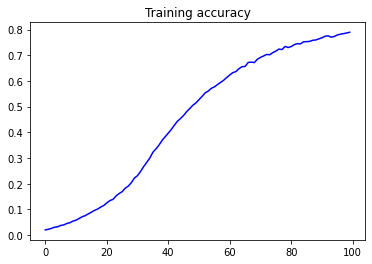

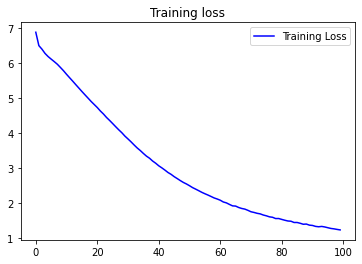

In [5]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [8]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope of manners holds her new state be clears go night of stand life away things lend his side cross judgment down by growth a son past be did privilege your face doth view an state set him true decay forth brought so forth confounds him thee thee forth told forth forth be men not be see your ' now give time's rhyme rhyme sounds sounds untrimm'd held decrease speed music burn exceeds decay days skill speed place thee back used changing several plot place thence prove things strong quite mother debt report rare rare torn dyed rolling place thence all
